In [111]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
try :
  import torchinfo
except :
  !pip install torchinfo
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from IPython.display import clear_output
np.float64()
try :
  from torch.utils.tensorboard import SummaryWriter
except :
  !pip install tensorboard

from torch.utils.tensorboard import SummaryWriter

# Function to approach

<class 'numpy.float64'>
10


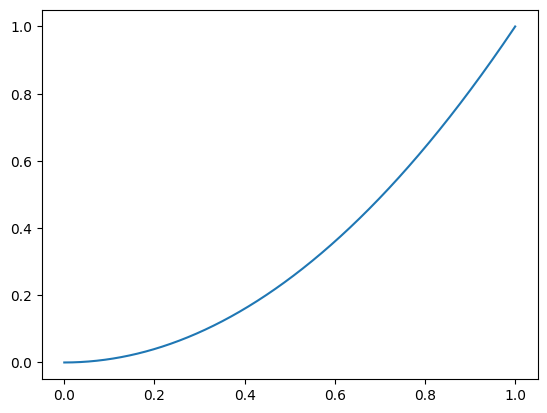

In [112]:
# function choice

def f(x):
  return  x**2

# set the points

abs = np.linspace(0,1,1000)
x_points = np.linspace(0,1,10)

# plot x f(x)

plt.plot(abs,f(abs))
print(type(abs[1]))
print(len(x_points))

In [113]:
# let's construct an approximation of f using a handcrafted NN with positive weights and sigmoid as activation function

# F(x) = a1.sig(w1.x+b1) + ..... + an.sig(wn.x+bn) + c

a = [0] + [f((x_points[i]+x_points[i+1])/2) - f((x_points[i-1]+x_points[i])/2) for i in range(1,len(x_points)-1)]

w = [1] + [100 for i in range(1,len(x_points)-1)]

b = [0] + [-w[i]*x_points[i] for i in range(1,len(x_points)-1)]

# def of the sigmoid activation

def sigmoid(x,w,b):
  return 1/(1+np.exp(-(w*x + b)))

# def of the positive NN

def handCraftedNN(x):
  sum = 0
  for i in range(len(x_points)-1):
    sum += a[i]*sigmoid(x,w[i],b[i])
  return sum



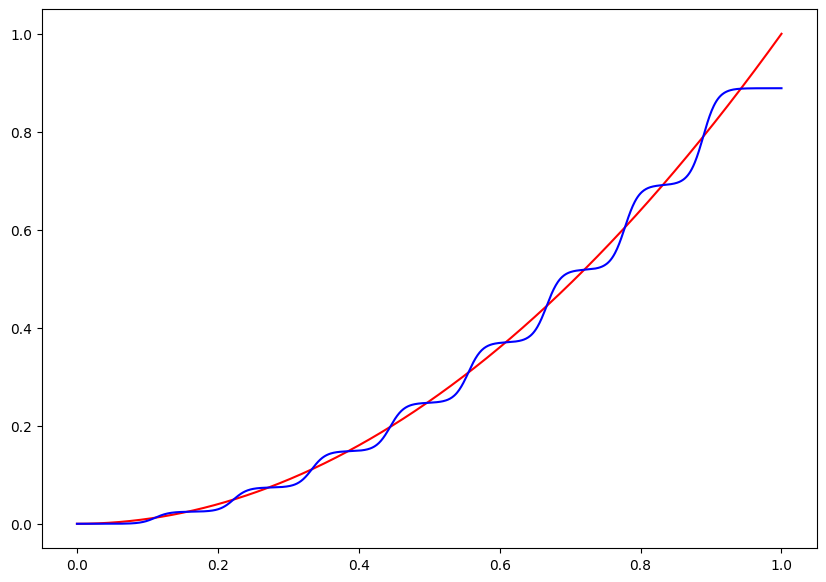

In [114]:
# plot the two curves

plt.figure(figsize=(10, 7))
plt.plot(abs,f(abs), c = 'r')
plt.plot(abs,handCraftedNN(abs), c = 'b')
plt.show()

# Data

In [115]:
###############################################################     here is the data part

BATCH_SIZE = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

torch.manual_seed(42)

data = torch.linspace(0, 1, steps=1000)
y_values = f(data)
dataset = TensorDataset(data.unsqueeze(1), y_values.unsqueeze(1))  # Ajoute une dimension pour correspondre à (N, 1)

# Séparez le dataset en ensembles d'entraînement et de test
TRAIN_SIZE = int(0.8 * len(dataset))
TEST_SIZE = len(dataset) - TRAIN_SIZE
train_dataset, test_dataset = random_split(dataset, [TRAIN_SIZE, TEST_SIZE])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


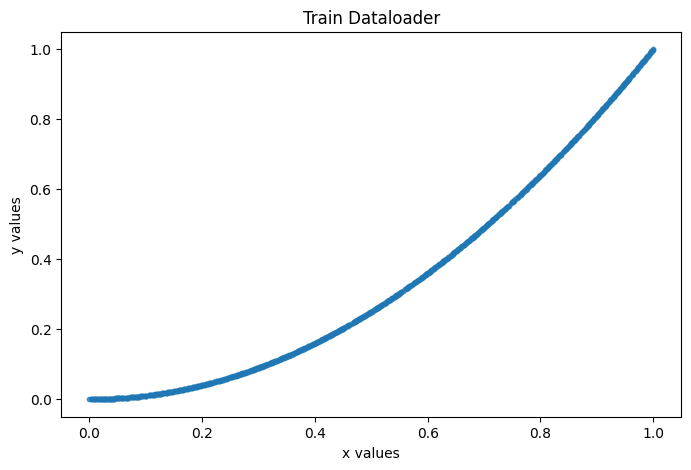

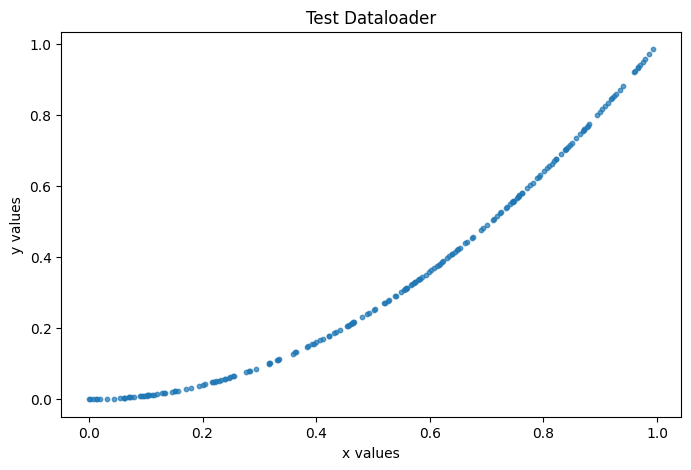

In [116]:
# Visualisation des données
def visualize_dataloader(dataloader, title):
    x_vals, y_vals = [], []
    for x, y in dataloader:
        x_vals.append(x.flatten())
        y_vals.append(y)
    x_vals = torch.cat(x_vals).numpy()
    y_vals = torch.cat(y_vals).numpy()

    plt.figure(figsize=(8, 5))
    plt.scatter(x_vals, y_vals, s=10, alpha=0.7)
    plt.xlabel("x values")
    plt.ylabel("y values")
    plt.title(title)
    plt.show()

# Visualiser le train_dataloader
visualize_dataloader(train_dataloader, "Train Dataloader")

# Visualiser le test_dataloader
visualize_dataloader(test_dataloader, "Test Dataloader")

# Model

In [117]:
class NN1(nn.Module):
  """
    Baseline 2-layer MLP: Linear → Sigmoid → Linear
    (no positivity constraints on the weights)
  """
  def __init__(self, in_features = 1, hidden_features = 8, out_features = 1):
    super().__init__()

    self.Linear1 = nn.Linear(in_features = in_features, out_features = hidden_features)
    self.Linear2 = nn.Linear(in_features = hidden_features, out_features = out_features)


  def forward(self, x):
    x = self.Linear2(torch.sigmoid(self.Linear1((x))))
    return x

class NN2(nn.Module):
  """
    Base class for 2-layer networks with explicitly parameterized weights
    and a configurable nonlinearity and positivity transform.

    W1, W2 are unconstrained parameters; a positivity transform is applied
    in the forward pass (e.g. softplus or square) to enforce W >= 0.

    Sigmoid activation.
  """
  def __init__(self, in_features = 1, hidden_features = 8, out_features = 1):
    super().__init__()

    self.W1 = nn.Parameter(torch.randn(hidden_features, in_features)+1)
    self.b1 = nn.Parameter(torch.zeros(hidden_features))

    self.W2 = nn.Parameter(torch.randn(out_features, hidden_features))
    self.b2 = nn.Parameter(torch.zeros(out_features))


  def forward(self, x):
    pos_w1 = F.softplus(self.W1)
    pos_w2 = F.softplus(self.W2)
    a = torch.sigmoid(F.linear(x,pos_w1,self.b1))
    x = F.linear(a,pos_w2,self.b2)
    return x

class NN3(nn.Module):
  """
    Base class for 2-layer networks with explicitly parameterized weights
    and a configurable nonlinearity and positivity transform.

    W1, W2 are unconstrained parameters; a positivity transform is applied
    in the forward pass (e.g. softplus or square) to enforce W >= 0.

    Relu activation.
  """
  def __init__(self, in_features = 1, hidden_features = 8, out_features = 1):
    super().__init__()

    self.W1 = nn.Parameter(torch.randn(hidden_features, in_features)+1)
    self.b1 = nn.Parameter(torch.zeros(hidden_features))

    self.W2 = nn.Parameter(torch.randn(out_features, hidden_features))
    self.b2 = nn.Parameter(torch.zeros(out_features))
    self.relu = nn.ReLU()


  def forward(self, x):
    pos_w1 = F.softplus(self.W1)
    pos_w2 = F.softplus(self.W2)
    a = self.relu(F.linear(x,pos_w1,self.b1))
    x = F.linear(a,pos_w2,self.b2)
    return x


class NN4(nn.Module):
  def __init__(self, in_features = 1, hidden_features = 8, out_features = 1):
    super().__init__()

    self.W1 = nn.Parameter(torch.randn(hidden_features, in_features)+1)
    self.b1 = nn.Parameter(torch.zeros(hidden_features))

    self.W2 = nn.Parameter(torch.randn(out_features, hidden_features))
    self.b2 = nn.Parameter(torch.zeros(out_features))


  def forward(self, x):
    pos_w1, pos_w2 = self.W1 ** 2, self.W2 ** 2
    a = torch.sigmoid(F.linear(x,pos_w1,self.b1))
    x = F.linear(a,pos_w2,self.b2)
    return x

In [118]:
model1 = NN1(in_features = 1, hidden_features = 8, out_features = 1).to(device)
model2 = NN2(in_features = 1, hidden_features = 8, out_features = 1).to(device)
model3 = NN3(in_features = 1, hidden_features = 8, out_features = 1).to(device)
model4 = NN4(in_features = 1, hidden_features = 8, out_features = 1).to(device)

# Train model

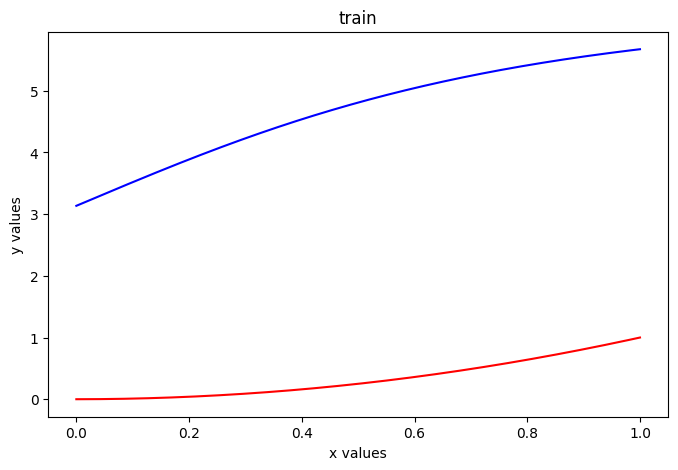

In [119]:
# Visualisation des données
def visualize_true_pred(model, dataloader, title):
    model.eval()
    x_vals, y_vals, pred_vals = [], [], []
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            pred = model(X)

            x_vals.append(X.flatten())
            y_vals.append(y)
            pred_vals.append(pred)


    x_vals = torch.cat(x_vals).numpy()
    y_vals = torch.cat(y_vals).numpy()
    pred_vals = torch.cat(pred_vals).numpy()

    sorted_indices = np.argsort(x_vals)
    x_vals = x_vals[sorted_indices]
    y_vals = y_vals[sorted_indices]
    pred_vals = pred_vals[sorted_indices]

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, y_vals, c='r')
    plt.plot(x_vals, pred_vals, c = 'b')

    plt.xlabel("x values")
    plt.ylabel("y values")
    plt.title(title)
    plt.show()

visualize_true_pred(model2, train_dataloader, "train")


In [120]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 1. do the forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    return train_loss

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    return test_loss


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "test_loss": [],
    }




    model.to(device)

    for epoch in tqdm(range(epochs), desc = "Training progress"):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        test_loss  = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              device=device)


        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # Plotting outside the loop
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(1, epochs + 1), results["train_loss"], label="Train Loss", color='b')
    ax.plot(range(1, epochs + 1), results["test_loss"], label="Test Loss", color='r')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training and Testing Loss over Epochs")
    ax.legend()
    ax.grid(True)
    plt.show()




    return results

In [121]:
my_optimizer2 = torch.optim.AdamW(params=model2.parameters(), lr=0.01)
my_loss_fn = nn.MSELoss()

Training progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000 | Train Loss: 17.3963 | Test Loss: 15.8507
Epoch 2/1000 | Train Loss: 14.1761 | Test Loss: 12.8641
Epoch 3/1000 | Train Loss: 11.4450 | Test Loss: 10.3579
Epoch 4/1000 | Train Loss: 9.1796 | Test Loss: 8.2937
Epoch 5/1000 | Train Loss: 7.3319 | Test Loss: 6.6162
Epoch 6/1000 | Train Loss: 5.8365 | Test Loss: 5.2684
Epoch 7/1000 | Train Loss: 4.6363 | Test Loss: 4.1928
Epoch 8/1000 | Train Loss: 3.6837 | Test Loss: 3.3346
Epoch 9/1000 | Train Loss: 2.9229 | Test Loss: 2.6526
Epoch 10/1000 | Train Loss: 2.3230 | Test Loss: 2.1081
Epoch 11/1000 | Train Loss: 1.8429 | Test Loss: 1.6755
Epoch 12/1000 | Train Loss: 1.4627 | Test Loss: 1.3310
Epoch 13/1000 | Train Loss: 1.1600 | Test Loss: 1.0570
Epoch 14/1000 | Train Loss: 0.9183 | Test Loss: 0.8398
Epoch 15/1000 | Train Loss: 0.7279 | Test Loss: 0.6667
Epoch 16/1000 | Train Loss: 0.5765 | Test Loss: 0.5288
Epoch 17/1000 | Train Loss: 0.4560 | Test Loss: 0.4193
Epoch 18/1000 | Train Loss: 0.3603 | Test Loss: 0.3324
Epoch 19/1000

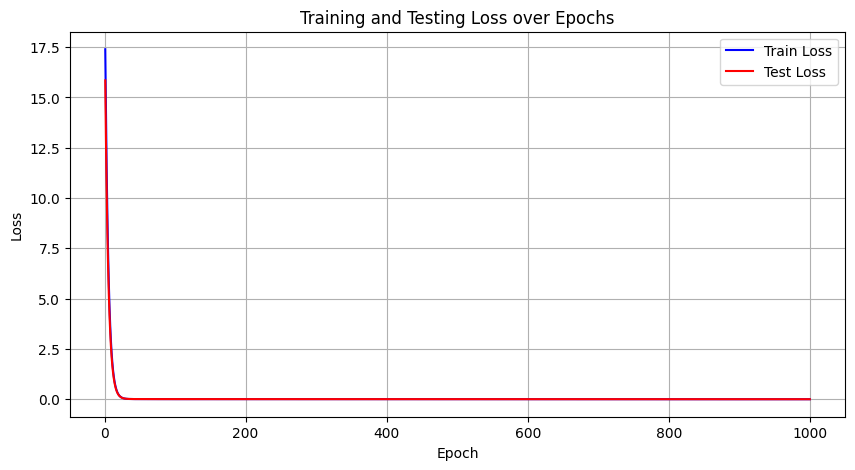

In [122]:
results = train(model = model2,
          train_dataloader = train_dataloader,
          test_dataloader = test_dataloader,
          optimizer = my_optimizer2,
          loss_fn = my_loss_fn,
          epochs = 1000,
          device = device)

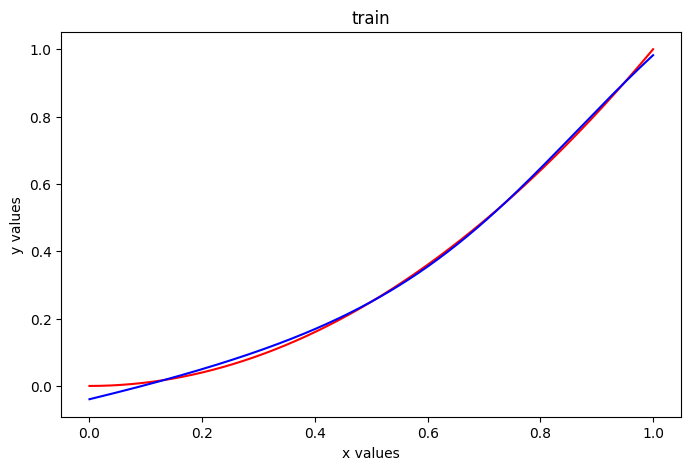

In [123]:
visualize_true_pred(model2, train_dataloader, "train")

In [124]:
my_optimizer3 = torch.optim.AdamW(params=model3.parameters(), lr=0.01)
my_loss_fn = nn.MSELoss()

Training progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500 | Train Loss: 1.4348 | Test Loss: 0.9648
Epoch 2/500 | Train Loss: 0.6145 | Test Loss: 0.3805
Epoch 3/500 | Train Loss: 0.2293 | Test Loss: 0.1367
Epoch 4/500 | Train Loss: 0.0877 | Test Loss: 0.0572
Epoch 5/500 | Train Loss: 0.0482 | Test Loss: 0.0384
Epoch 6/500 | Train Loss: 0.0417 | Test Loss: 0.0349
Epoch 7/500 | Train Loss: 0.0398 | Test Loss: 0.0327
Epoch 8/500 | Train Loss: 0.0369 | Test Loss: 0.0298
Epoch 9/500 | Train Loss: 0.0332 | Test Loss: 0.0267
Epoch 10/500 | Train Loss: 0.0295 | Test Loss: 0.0242
Epoch 11/500 | Train Loss: 0.0264 | Test Loss: 0.0221
Epoch 12/500 | Train Loss: 0.0239 | Test Loss: 0.0201
Epoch 13/500 | Train Loss: 0.0215 | Test Loss: 0.0182
Epoch 14/500 | Train Loss: 0.0193 | Test Loss: 0.0162
Epoch 15/500 | Train Loss: 0.0172 | Test Loss: 0.0144
Epoch 16/500 | Train Loss: 0.0153 | Test Loss: 0.0128
Epoch 17/500 | Train Loss: 0.0135 | Test Loss: 0.0113
Epoch 18/500 | Train Loss: 0.0119 | Test Loss: 0.0099
Epoch 19/500 | Train Loss: 0.0104 | T

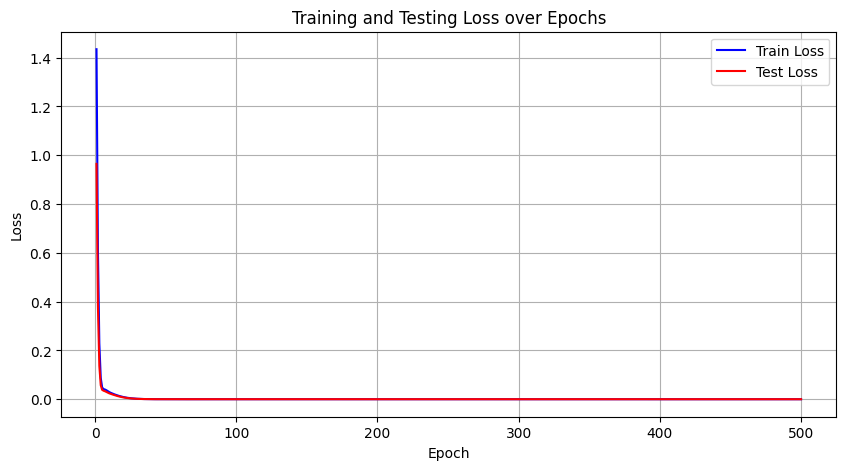

In [125]:
results = train(model = model3,
          train_dataloader = train_dataloader,
          test_dataloader = test_dataloader,
          optimizer = my_optimizer3,
          loss_fn = my_loss_fn,
          epochs = 500,
          device = device)

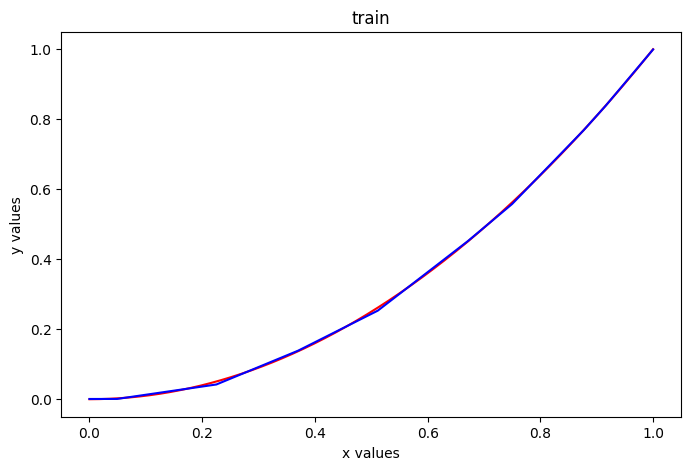

In [126]:
visualize_true_pred(model3, train_dataloader, "train")

In [127]:
my_optimizer4 = torch.optim.AdamW(params=model4.parameters(), lr=0.01)
my_loss_fn = nn.MSELoss()

Training progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000 | Train Loss: 30.7473 | Test Loss: 24.5737
Epoch 2/1000 | Train Loss: 20.2868 | Test Loss: 16.0460
Epoch 3/1000 | Train Loss: 13.2411 | Test Loss: 10.4812
Epoch 4/1000 | Train Loss: 8.7150 | Test Loss: 6.9351
Epoch 5/1000 | Train Loss: 5.8256 | Test Loss: 4.6900
Epoch 6/1000 | Train Loss: 3.9890 | Test Loss: 3.2484
Epoch 7/1000 | Train Loss: 2.8009 | Test Loss: 2.3013
Epoch 8/1000 | Train Loss: 2.0093 | Test Loss: 1.6637
Epoch 9/1000 | Train Loss: 1.4705 | Test Loss: 1.2233
Epoch 10/1000 | Train Loss: 1.0930 | Test Loss: 0.9123
Epoch 11/1000 | Train Loss: 0.8240 | Test Loss: 0.6881
Epoch 12/1000 | Train Loss: 0.6279 | Test Loss: 0.5242
Epoch 13/1000 | Train Loss: 0.4831 | Test Loss: 0.4029
Epoch 14/1000 | Train Loss: 0.3760 | Test Loss: 0.3119
Epoch 15/1000 | Train Loss: 0.2947 | Test Loss: 0.2434
Epoch 16/1000 | Train Loss: 0.2328 | Test Loss: 0.1919
Epoch 17/1000 | Train Loss: 0.1860 | Test Loss: 0.1529
Epoch 18/1000 | Train Loss: 0.1506 | Test Loss: 0.1233
Epoch 19/1000

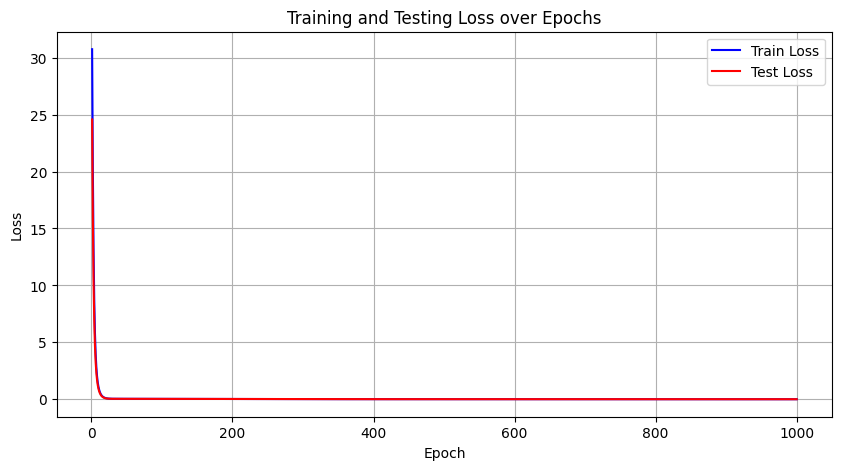

In [128]:
results = train(model = model4,
          train_dataloader = train_dataloader,
          test_dataloader = test_dataloader,
          optimizer = my_optimizer4,
          loss_fn = my_loss_fn,
          epochs = 1000,
          device = device)

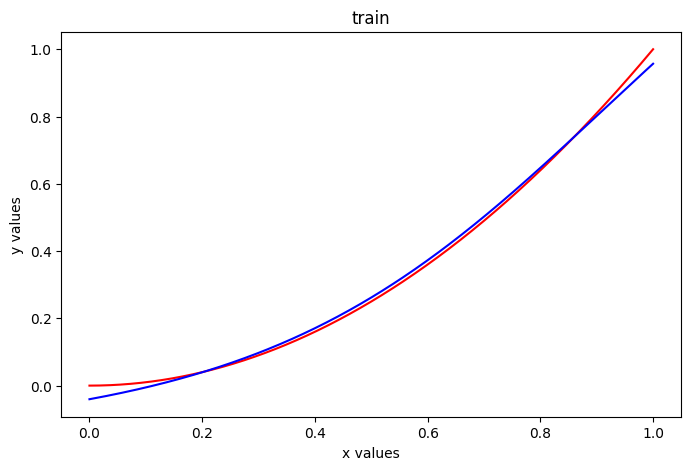

In [129]:
visualize_true_pred(model4, train_dataloader, "train")

In [130]:
abs_tensor = torch.tensor(abs, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension si nécessaire


y_true1 = torch.tensor([f(x) for x in abs], dtype=torch.float32).unsqueeze(1)


dataset1 = TensorDataset(abs_tensor, y_true1)


dataloader = DataLoader(dataset1, batch_size=100, shuffle=False)

test_loss = test_step(model2, dataloader, my_loss_fn, device)
print(f"Test Loss avec DataLoader basé sur abs : {test_loss}")

Test Loss avec DataLoader basé sur abs : 0.00011244649595028022


In [131]:
test_step(model2,
          test_dataloader,
          my_loss_fn,
          device)

0.00010364164700149558